In [1]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt
import scipy.stats as SSA
from scipy.stats import gaussian_kde

In [2]:
df_scores = pd.read_csv('../results/scores/survey_scores_perinfo.csv')

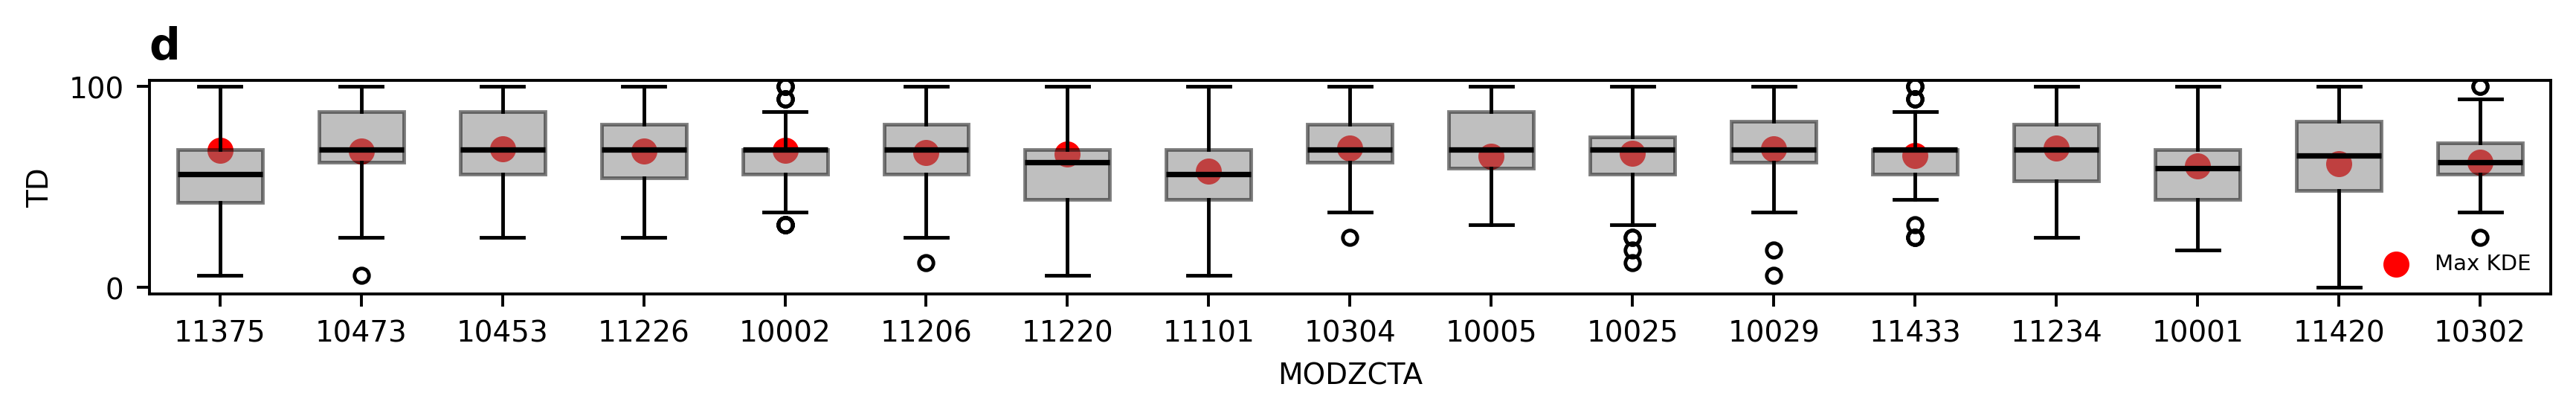

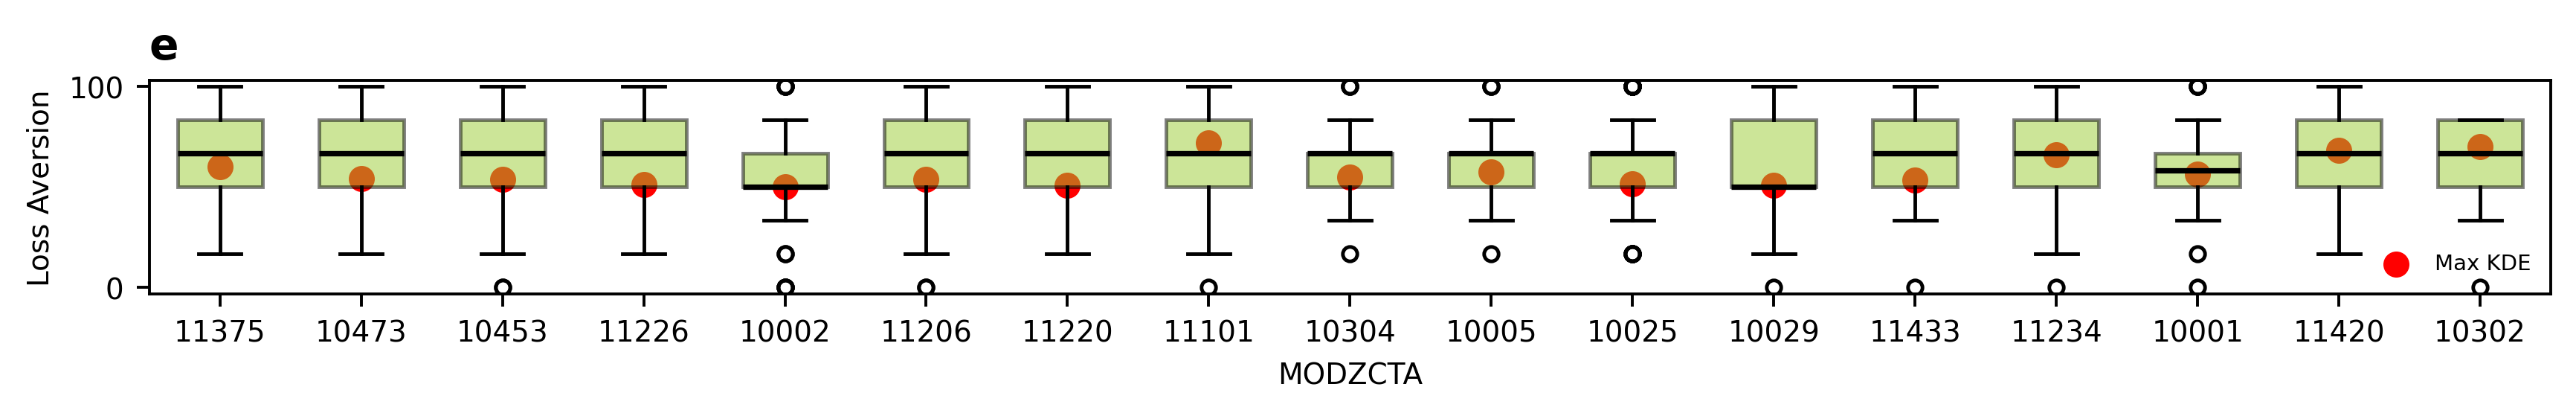

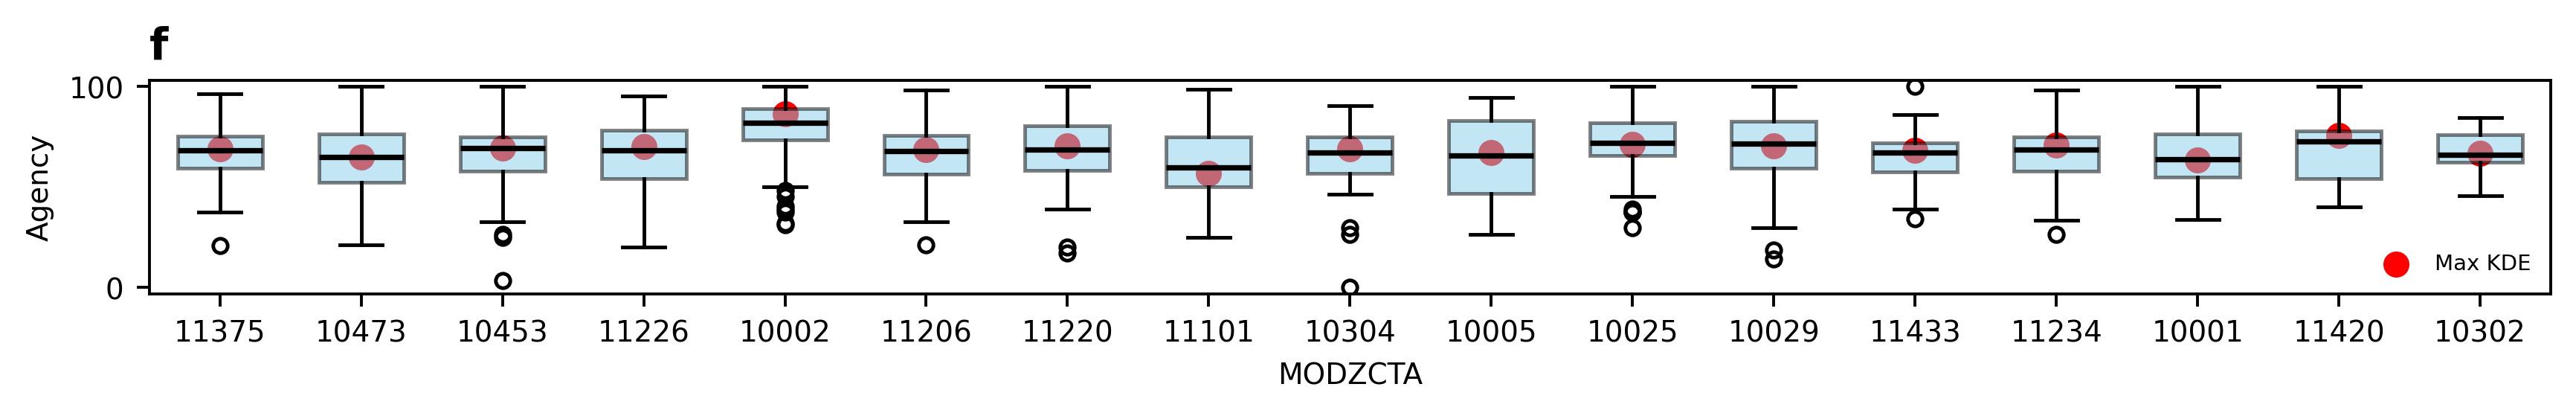

In [25]:
for score_name in ['regulated_tdscores','regulated_loss','regulated_agency']:
    # score_name  = 'regulated_tdscores'
    df_i = df_scores[df_scores['modzcta_count']>15][[score_name,'MODZCTA']]
    # grouped = df_i.groupby('MODZCTA')
    plt.figure(figsize=(10, 1.7),dpi=350)
    for i, group in enumerate(df_i['MODZCTA'].unique()):
        # Extract the group data
        group_data = df_i[df_i['MODZCTA'] == group][score_name]
        # Calculate median
        median_val = np.median(group_data)
        # Calculate mode (mode can have multiple values, we'll take the first mode)
        # mode_val = SSA.mode(group_data)[0]
        kde = gaussian_kde(group_data)
        x_vals = np.linspace(min(group_data), max(group_data), 1000)  # Create a range of values for KDE
        kde_vals = kde(x_vals)
        max_kde_val = x_vals[np.argmax(kde_vals)]
        kde_vals = kde_vals / kde_vals.max() * 0.6  # Scale to control width of the violin
        # Create the violin shape
        color_fill = {'regulated_tdscores': 'grey', 'regulated_loss': 'yellowgreen', 'regulated_agency': 'skyblue'}[score_name]
        # plt.fill_betweenx(x_vals, i, i + kde_vals, color=color_fill, alpha=0.4)
        plt.boxplot(group_data, positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color_fill, color='black',alpha = 0.5), whiskerprops=dict(color='black'), capprops=dict(color='black'), flierprops=dict(marker='o', markerfacecolor='none', markersize=4, linestyle='none'), medianprops=dict(color='black',linewidth=1.5))
        # Calculate median
        median_val = np.median(group_data)
        # Find the maximum of the KDE
        max_kde_val = x_vals[np.argmax(kde_vals)]
        # Plot median as a dashed line
        # plt.plot([i, i + 0.6], [median_val, median_val], color='black', linestyle='--', linewidth=1.2, label='Median' if i == 0 else "")
        # Plot max KDE as a solid line
        # plt.plot([i-0.3, i + 0.3], [max_kde_val, max_kde_val], color='red', linestyle='-', linewidth=1.2, label='Max KDE' if i == 0 else "")
        plt.scatter(i, max_kde_val, color='red', linestyle='-', linewidth=1.2, label='Max KDE' if i == 0 else "")
    # plt.axhline(y=50, color='grey', linewidth=0.5)
    # Add legend without frame
    plt.legend(frameon=False, fontsize=6, loc='lower right')
    plt.ylim(-3,103)
    # Set axis properties
    plt.xticks(range(len(df_i['MODZCTA'].unique())), df_i['MODZCTA'].unique(), fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('MODZCTA',fontsize=8)
    y_name = {'regulated_tdscores':'TD','regulated_loss':'Loss Aversion','regulated_agency':'Agency'}[score_name]
    plt.ylabel(y_name,fontsize=8)
    # Set frame linewidth
    # plt.gca().spines['top'].set_linewidth(0.5)
    # plt.gca().spines['right'].set_linewidth(0.5)
    # plt.gca().spines['left'].set_linewidth(0.5)
    # plt.gca().spines['bottom'].set_linewidth(0.5)
    title_name = {'regulated_tdscores':'d','regulated_loss':'e','regulated_agency':'f'}[score_name]
    plt.title(title_name, fontsize=12,loc='left',fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/plots_maps/box_per_zcta_{}.png'.format(score_name),dpi=350, bbox_inches='tight')
    # plt.show()

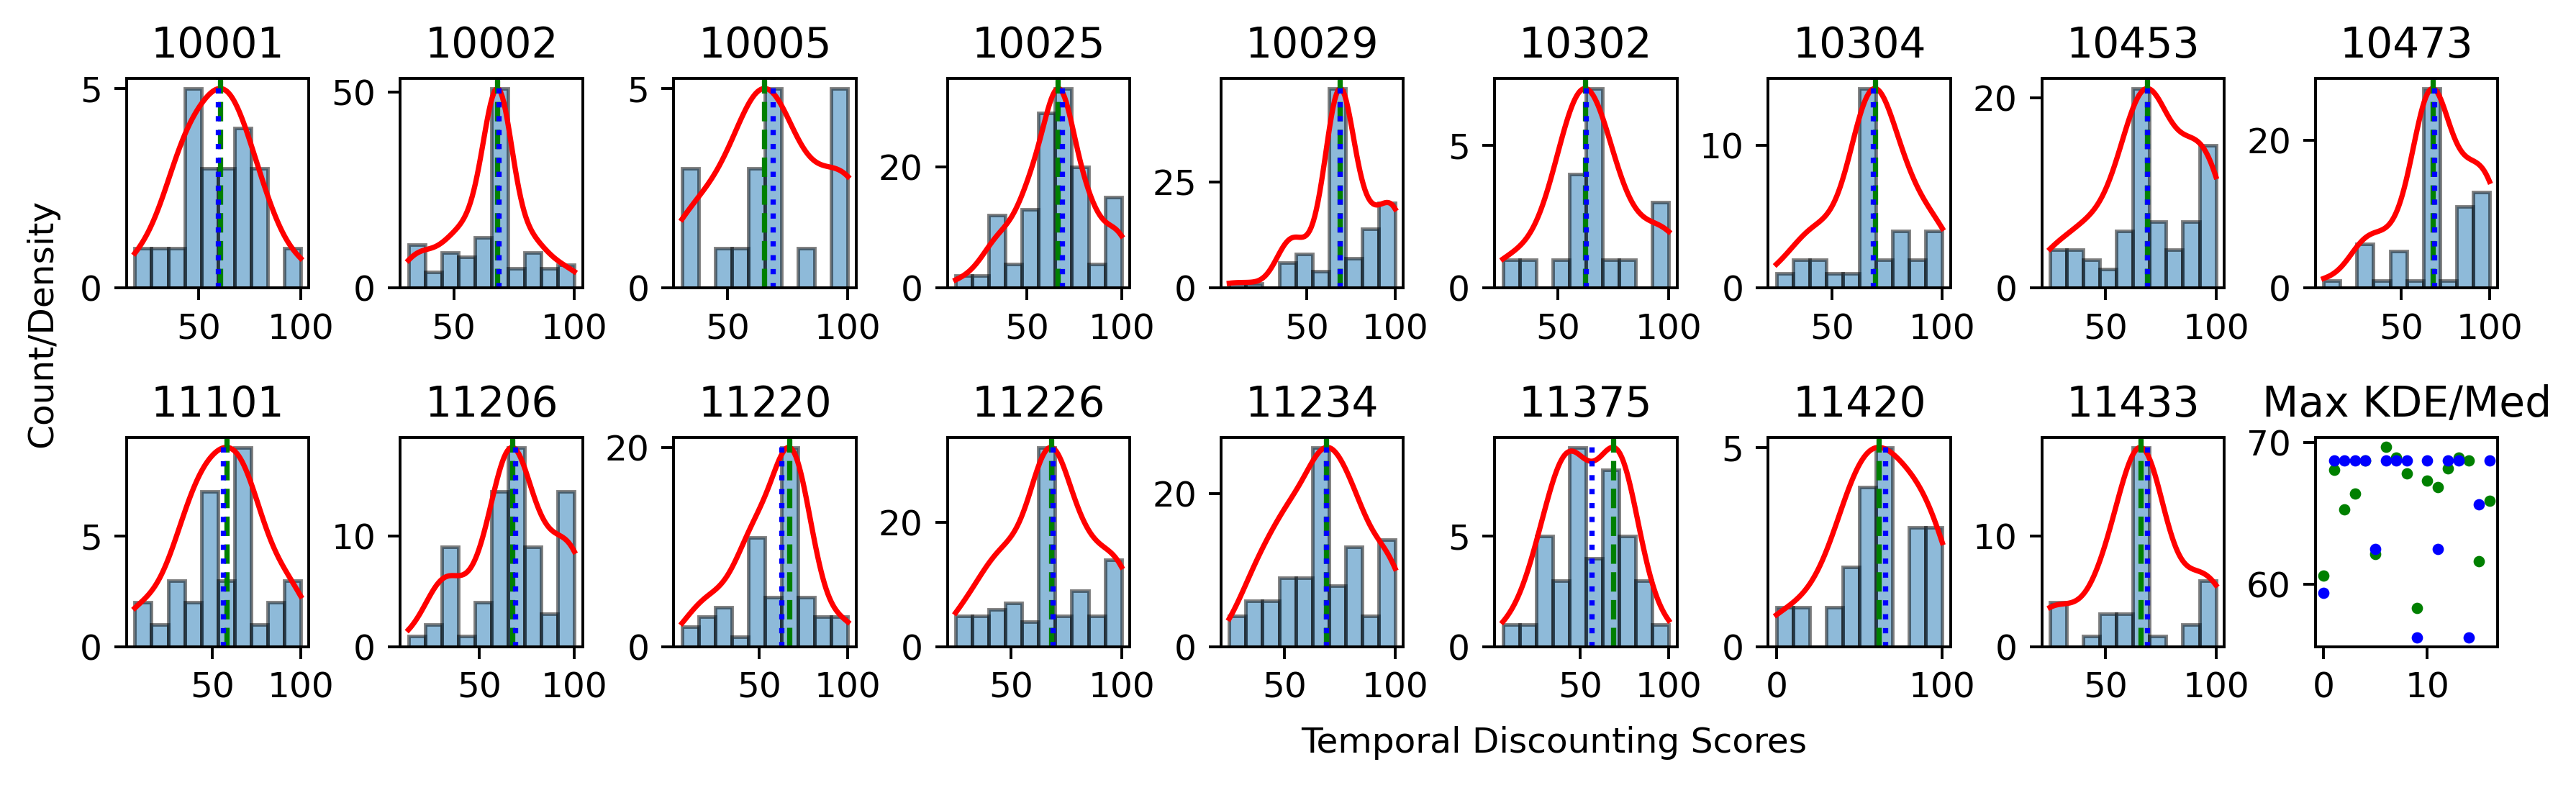

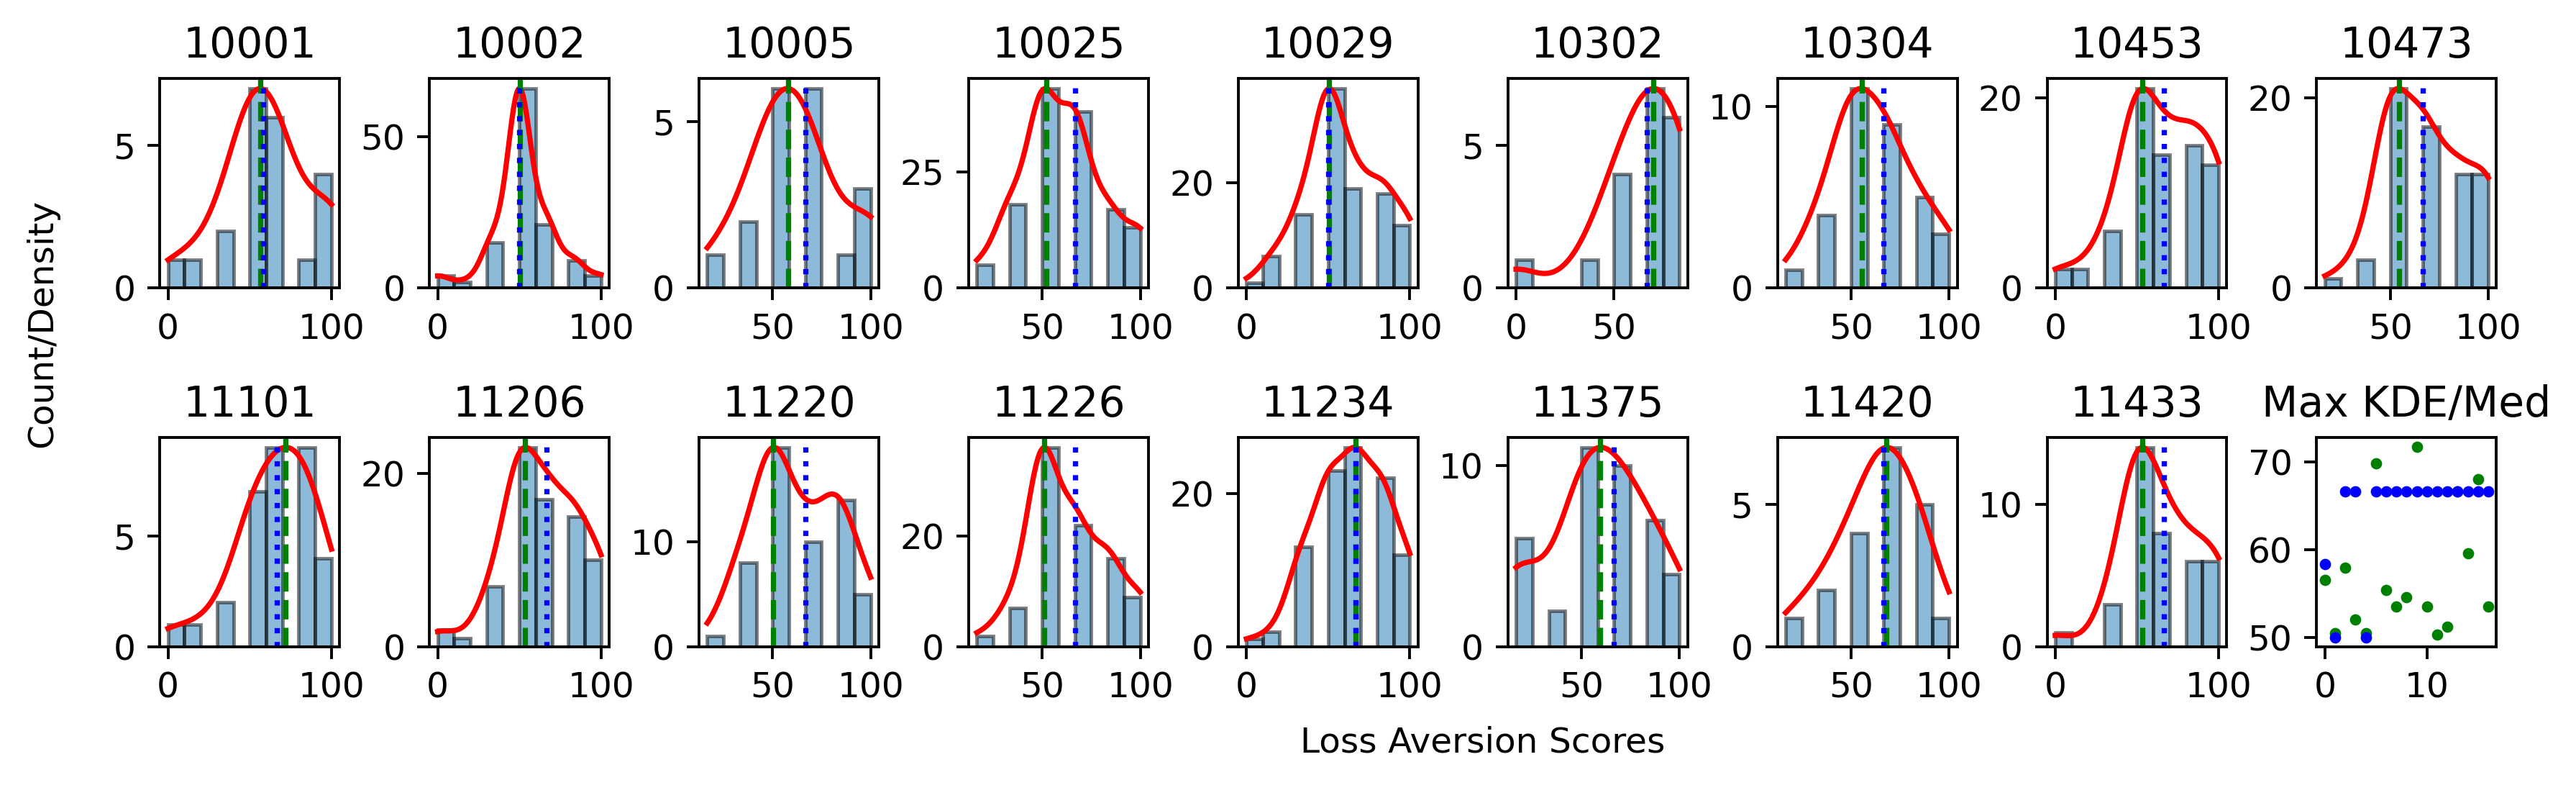

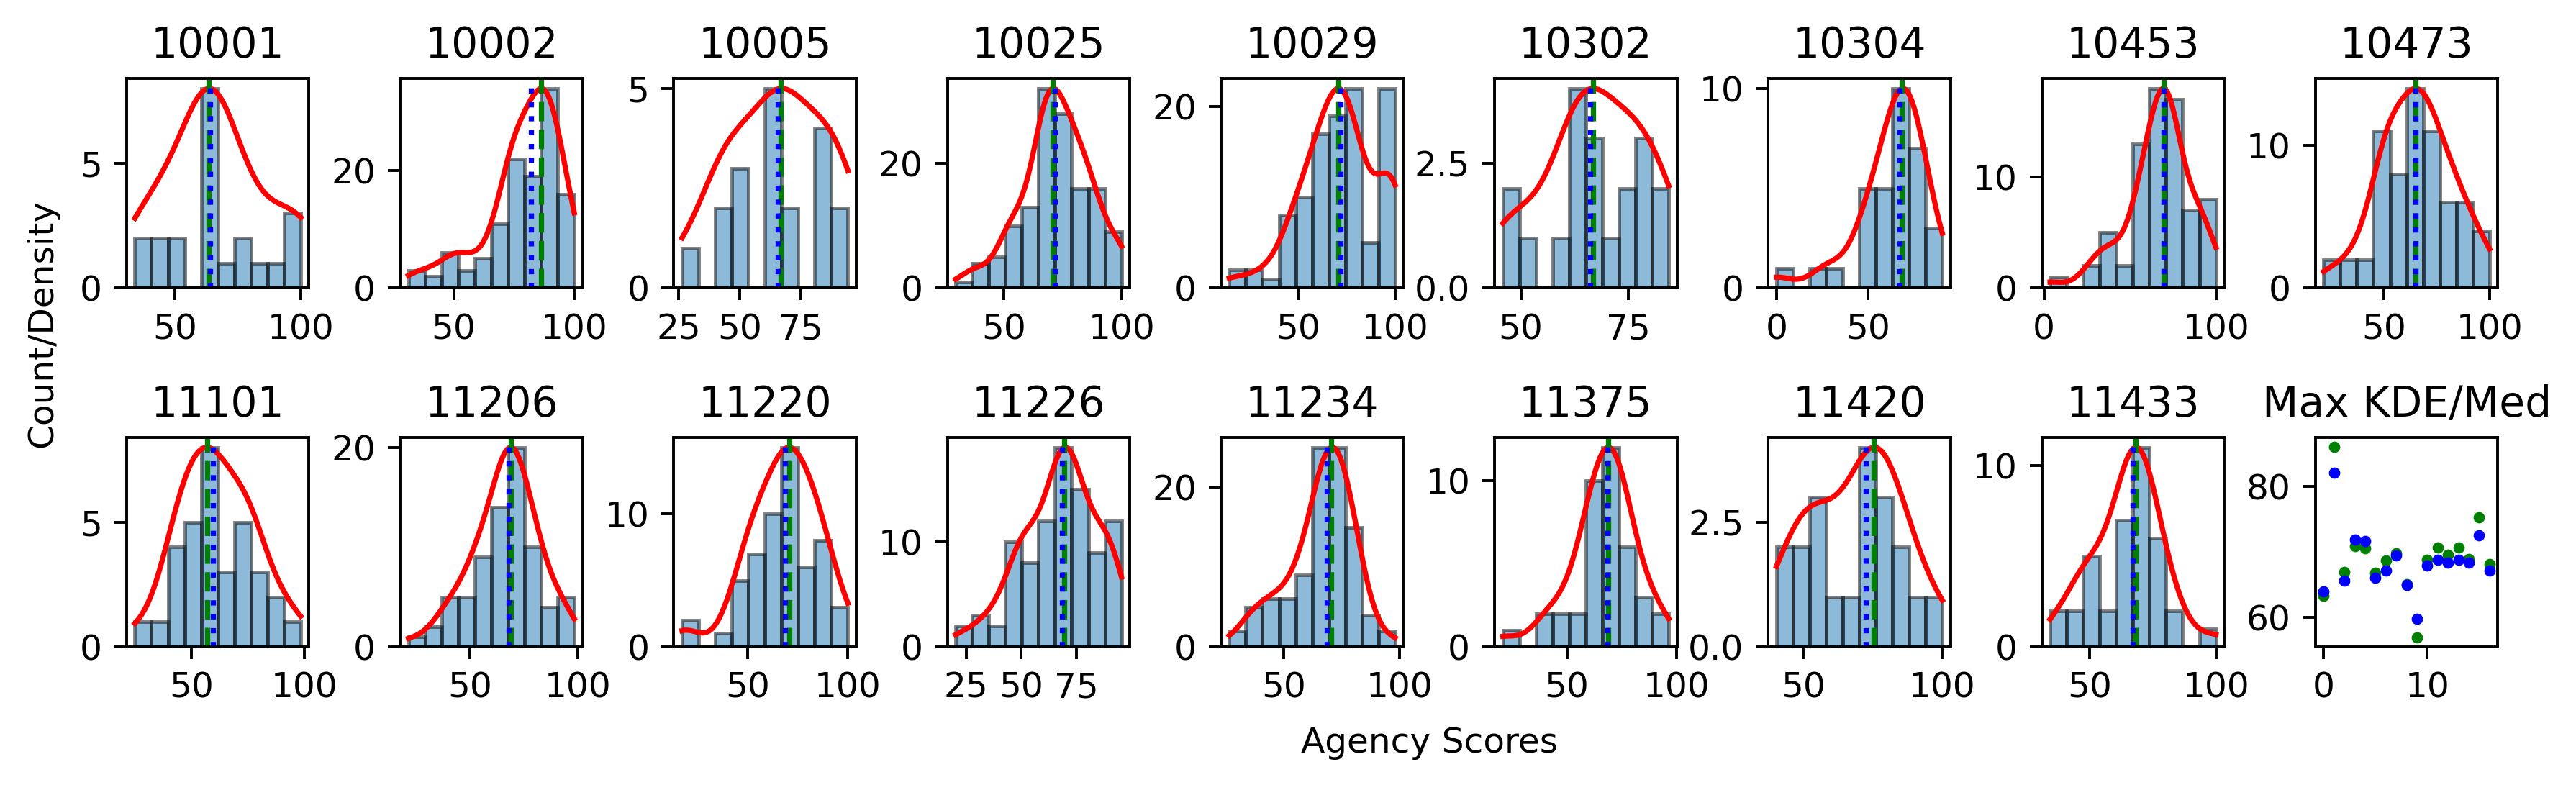

In [20]:
for score_name in ['regulated_tdscores','regulated_loss','regulated_agency']:
    df_i = df_scores[df_scores['modzcta_count']>15][[score_name,'MODZCTA']]
    grouped = df_i.groupby('MODZCTA')
    fig, axs = plt.subplots(2, 9, figsize=(10, 3),dpi=350)
    axs = axs.flatten()
    # Plot histograms for each group
    modes = {}
    medians = {}
    for i, (name, group) in enumerate(grouped):
        counts, bins, patches = axs[i].hist(group[score_name], bins=10, edgecolor='black', alpha=0.5)
        
        # KDE using gaussian_kde
        kde = gaussian_kde(group[score_name], bw_method='scott')
        x_vals = np.linspace(min(group[score_name]), max(group[score_name]), 100)
        kde_vals = kde(x_vals)
        
        # ax_kde = axs[i].twinx()
        # ax_kde.plot(x_vals, kde_vals, color='red')
        axs[i].plot(x_vals, kde_vals * max(counts) / max(kde_vals), color='red')  # Scale KDE to fit histogram
        
        mode_index = np.argmax(kde_vals)
        mode_value = x_vals[mode_index]
        modes[name] = mode_value
        # axs[i].hist(group['regulated_tdscores'], bins=10, edgecolor='black')
        median_value = np.median(group[score_name])
        medians[name] = median_value
        axs[i].set_title(f'{name}')
        
        axs[i].axvline(mode_value, color='green', linestyle='--')
        # ax_kde.text(mode_value, max(kde_vals), f'Mode: {mode_value:.2f}', color='green', ha='center')

        axs[i].axvline(median_value, color='blue', linestyle=':')
        # ax_kde.text(median_value, max(kde_vals) * 0.8, f'Median: {median_value:.2f}', color='blue', ha='center')
    # Hide any unused subplots
    axs[i+1].scatter(range(len(modes)),modes.values(), color='green', label='Mode',s=5)
    axs[i+1].scatter(range(len(medians)),medians.values(), color='blue', label='Median',s=5) 
    axs[i+1].set_title('Max KDE/Med')
    # for j in range(i+1, len(axs)):
    #     axs[j].set_visible(False)
    title_name = {'regulated_tdscores':'Temporal Discounting Scores','regulated_loss':'Loss Aversion Scores','regulated_agency':'Agency Scores'}[score_name]
    fig.text(0.0, 0.4, 'Count/Density', ha='center', rotation='vertical', fontsize=10)  # y-label
    fig.text(0.5, 0.0, title_name, va='center', fontsize=10)  # x-label


    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)

    plt.savefig('../results/plots_maps/hist_per_zcta_{}.png'.format(score_name),dpi=350, bbox_inches='tight')

In [21]:
def compute_mode(values):
    if len(values) == 1:  # If only one value, return it as the mode
        return values.iloc[0]
    kde = gaussian_kde(values)
    x_vals = np.linspace(min(values), max(values), 100)
    kde_vals = kde(x_vals)
    mode = x_vals[np.argmax(kde_vals)]
    return mode

# Group by MODZCTA and calculate the mode for each score
df_s = df_scores[df_scores['modzcta_count']>15][['regulated_tdscores','regulated_loss','regulated_agency','MODZCTA']]
df_mode = df_s.groupby('MODZCTA').apply(lambda x: pd.Series({
    'regulated_tdscores_mode': compute_mode(x['regulated_tdscores']),
    'regulated_loss_mode': compute_mode(x['regulated_loss']),
    'regulated_agency_mode': compute_mode(x['regulated_agency']),
})).reset_index()

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_31787/928309374.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mode = df_s.groupby('MODZCTA').apply(lambda x: pd.Series({


In [22]:
df_mode

,MODZCTA,regulated_tdscores_mode,regulated_loss_mode,regulated_agency_mode
0,10001,60.606061,56.565657,63.293651
1,10002,68.055556,50.505051,86.111111
2,10005,65.277778,57.912458,66.947250
3,10025,66.414141,52.020202,70.880682
4,10029,68.750000,50.505051,70.562771
5,10302,62.121212,69.865320,66.856061
6,10304,69.696970,55.387205,68.655303
7,10453,68.939394,53.535354,69.805195
8,10473,67.803030,54.545455,65.079365
9,11101,58.333333,71.717172,56.897096


In [24]:
df_mode.to_csv('../results/scores/modzcta_scores_mode.csv',index=False)